In [1]:
import sys


In [2]:
%matplotlib inline

import underworld as uw
from underworld import function as fn
import glucifer
import math
from libUnderworld import petsc

from math import sin, cos
import numpy as np
import matplotlib.pyplot as mplt
import matplotlib.pylab as pylab
from matplotlib.colors import LogNorm


## Create a FEM mesh: defining element resolution, domain size, etc.

In [3]:
dim = 2

ires = 104
jres = 48

xmin, xmax = -200e3, 200e3
ymin, ymax = -160e3, 15e3

elementMesh = uw.mesh.FeMesh_Cartesian(elementType = 'Q1/dQ0', 
                                       elementRes = (ires, jres), 
                                       minCoord = (xmin, ymin), 
                                       maxCoord = (xmax, ymax))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

## Define mesh variables
Notes: nodeDofCount means how many variables does this field need? Temperature is scalar, so it needs 1, velocity is vector, so it needs 2/3.

In [4]:
velocityField = uw.mesh.MeshVariable(mesh = linearMesh, nodeDofCount = dim)
pressureField = uw.mesh.MeshVariable(mesh = constantMesh, nodeDofCount = 1)
temperatureField = uw.mesh.MeshVariable(mesh = linearMesh, nodeDofCount = 1)
temperatureDotField = uw.mesh.MeshVariable(mesh = linearMesh, nodeDofCount = 1)


strainRateInvField = uw.mesh.MeshVariable(mesh = linearMesh, nodeDofCount = 1)

## Define swarm variables
These are typically properties that you need to track through time, such as total strain or material type.

In [5]:
swarm = uw.swarm.Swarm(linearMesh, particleEscape = True)

material_index = swarm.add_variable('char', 1)
visc = swarm.add_variable('double', 1)

# Fill the mesh with particles
layout = uw.swarm.layouts.GlobalSpaceFillerLayout(swarm, 40)
swarm.populate_using_layout(layout)

## Define material shapes

In [6]:
# create some misc shapes
coord = fn.input()

# create some misc shapes
airShape = (coord[1] <= 15e3) & (coord[1] > 0.)
upperShape = (coord[1] <= 0.) & (coord[1] > -20e3)
lowerShape = (coord[1] <= -20e3) & (coord[1] > -40e3)
mantleShape = (coord[1] <= -40e3) & (coord[1] >= -160e3)
notchShape = (coord[1] <= -15e3) & (coord[1] > -20e3) & (coord[0] >= -10e3) & (coord[0] <= 10e3)

airIndex = 1
uppercrustIndex = 2
lowercrustIndex = 3
mantleIndex = 4
notchIndex = 5

material_index.data[:] = fn.branching.conditional(
    [ #  Which ever condition returns True first is used (hence why notchShape is before upperShape)
        (mantleShape, mantleIndex),
        (lowerShape, lowercrustIndex),
        (notchShape, notchIndex),
        (upperShape, uppercrustIndex),
        (airShape, airIndex),
        (True, -1),
    ]).evaluate(swarm)


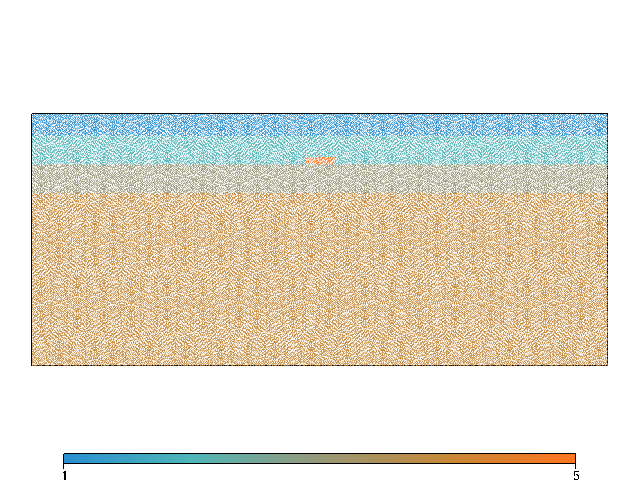

In [7]:

fig = glucifer.Figure()
#fig.append( glucifer.objects.Mesh(linearMesh) )
fig.append( glucifer.objects.Points(swarm, fn_colour=material_index, pointSize=1.0 ) )
fig.show()

## Rheological Properties

Setup material properties either as a dictionary with each index, or as a single value for materials to share.

In [8]:
# single value to be used for all materials
thermal_exp = 5e-3
diffusivity = 1e-6

# dictionary to map out value for each material
radiogenic_heat_map = {airIndex: 0., 
                       uppercrustIndex: 1.2e-6, 
                       notchIndex: 1.2e-5, 
                       lowercrustIndex: 0.6e-6,
                       mantleIndex: 0.02e-6,}

heat_capacity_map = {airIndex: 1000., 
                     uppercrustIndex: 1000., 
                     notchIndex: 1000., 
                     lowercrustIndex: 1000.,
                     mantleIndex: 1000.,}

density_map = {airIndex: 1., 
               uppercrustIndex: 2800., 
               notchIndex: 2800., 
               lowercrustIndex: 2900.,
               mantleIndex: 3300.,}

Now we map those dictionaries to each material by using the map function.

If we need a special case, like in the thermal_density_func, we can use a branching conditional function to set distinct behavior

In [9]:
radiogenic_heat_Fn = fn.branching.map(fn_key = material_index, mapping = radiogenic_heat_map)

heat_capacity_Fn = fn.branching.map(fn_key = material_index, mapping = heat_capacity_map)




densityFn = fn.branching.map(fn_key = material_index, mapping = density_map)

# we don't want air convecting, so it has no heat dependence.
thermal_density_func = fn.branching.conditional([
                         (material_index == airIndex, 1. ),  
                         (True, densityFn - (thermal_exp * (temperatureField - 273.15)) ),])

conductivity_Fn = fn.branching.conditional([(airShape, 10000.),  # we want the air to be as "transparent" as much as possible.
                                            (True, diffusivity * thermal_density_func * heat_capacity_Fn,)])

diffusivity_Fn = fn.branching.conditional([(airShape, 1e2),  # we want the air to be as "transparent" as much as possible.
                                           (True, 2.)])

heating_Fn = radiogenic_heat_Fn #* 1e7 / (thermal_density_func * heat_capacity_Fn)

## Initialise temperature to steady-state geotherm

In [10]:
# declare which nodes are to be considered as boundary nodes
topNodes = linearMesh.specialSets["MaxJ_VertexSet"] 
bottomNodes = linearMesh.specialSets["MinJ_VertexSet"]

# init tempfield to 0C everywhere
temperatureField.data[:] = 273.15

# On the bottom and top of our model, set what the boundary condition will be
temperatureField.data[topNodes.data]    = 273.15
temperatureField.data[bottomNodes.data] = 1623.15

# Now tell UW that these boundaries shouldn't be touched
temp_BC = uw.conditions.DirichletCondition(temperatureField, topNodes + bottomNodes)

In [11]:
ssheat = uw.systems.SteadyStateHeat(temperatureField, 
                                    diffusivity_Fn, 
                                    fn_heating = heating_Fn,
                                    conditions = [temp_BC,])
heatsolver = uw.systems.Solver(ssheat)
heatsolver.solve(nonLinearIterate=True)

## Display the thermal structure of the model

Here we can use Numpy to make a nice little plot of elevation vs temp.

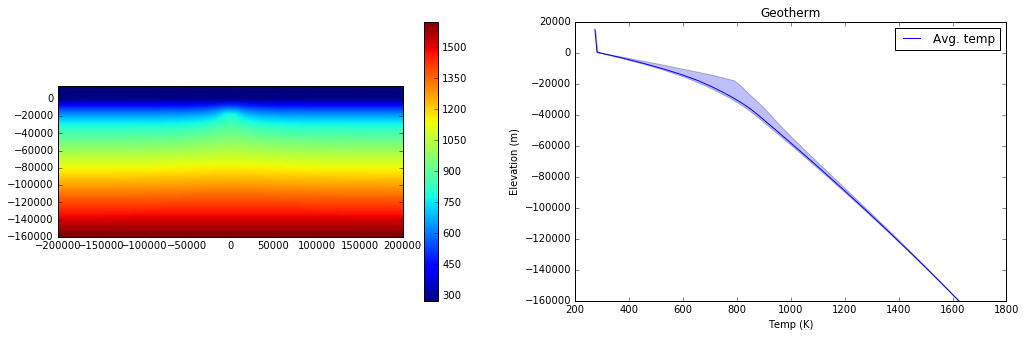

In [12]:
temp_2d = temperatureField.data.reshape((jres+1,ires+1))
mplt.figure(figsize=(17,5))
mplt.subplot(121)
mplt.imshow(temp_2d, 
            origin = 'lower',
            extent = (xmin, xmax, ymin, ymax))
mplt.colorbar()

mplt.subplot(122)
geotherm = np.average(temp_2d, axis=1)
geotherm_min = np.min(temp_2d, axis=1)
geotherm_max = np.max(temp_2d, axis=1)
depth = np.linspace(ymin, ymax, geotherm.shape[0])

mplt.plot(geotherm, depth, label = "Avg. temp")
mplt.fill_betweenx(depth, geotherm_min, geotherm_max, facecolor='blue', alpha=0.25)

mplt.title("Geotherm")
mplt.ylabel("Elevation (m)")
mplt.xlabel("Temp (K)")
mplt.legend(loc="best")

In [13]:
# Bit of a hack - we used the notch to make a hotspot - now we undo that by giving it the same
# properties as the upper crust.
radiogenic_heat_map[notchIndex] = radiogenic_heat_map[uppercrustIndex]

# Mechanical properties

In [14]:
# Initialise data.
vel_init_fn_x = coord[0] / ((np.abs(xmax) - np.min(xmin))/2.) * 3.16887646e-10  # Guess that on the edges we'll be going about 1 cm/yr either direction
vel_init_fn_y = -(coord[1] - xmin) / ((np.abs(ymax) - np.min(ymin))) * 3.16887646e-10  # Since we have no isostasy, guess that at the bottom it's zero, and it increases above
velocityField.data[:] = np.hstack((vel_init_fn_x.evaluate(linearMesh), vel_init_fn_y.evaluate(linearMesh)))

sri_Fn = fn.tensor.second_invariant( 
                fn.tensor.deviatoric(
                    fn.tensor.symmetric ( 
                        velocityField.fn_gradient )) )
strainRateInvField.data[:] = sri_Fn.evaluate(linearMesh)

velocityField.data[:] = [0,0]
strainRateInvField.data[:] = 1e-15

pseudopressure = -coord[1] * 9.81 * 3000.  # Take a guess at the pressure
pressureField.data[:] = pseudopressure.evaluate(constantMesh)
pressureField.data[pressureField.data <= 0.] = 1.  # Make everything > 0.

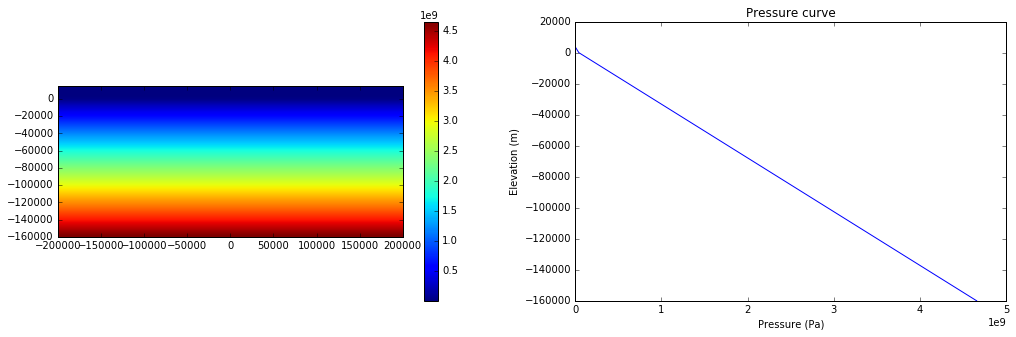

In [15]:
mplt.figure(figsize=(17,5))
mplt.subplot(121)
mplt.imshow(pressureField.data.reshape((jres,ires)), 
            origin = 'lower',
            extent = (xmin, xmax, ymin, ymax))
mplt.colorbar()

mplt.subplot(122)
avgpresure = np.average(pressureField.data.reshape((jres, ires)), axis=1)
depth = np.linspace(linearMesh.minCoord[1], linearMesh.maxCoord[1], avgpresure.shape[0])
mplt.plot(avgpresure, depth)

mplt.title("Pressure curve")
mplt.ylabel("Elevation (m)")
mplt.xlabel("Pressure (Pa)")


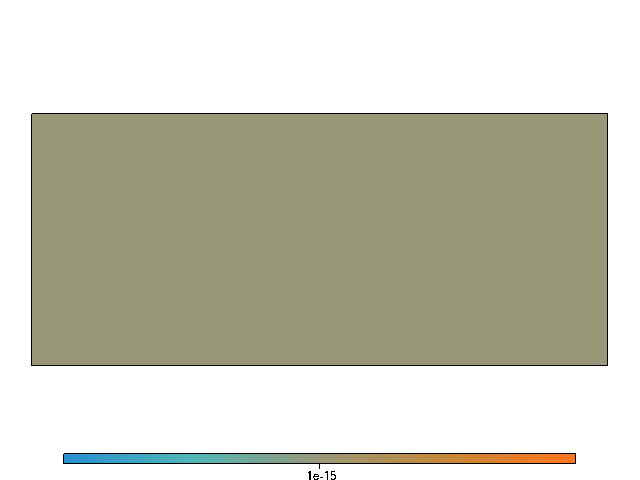

In [16]:
figsri = glucifer.Figure()
figsri.append( glucifer.objects.Surface( linearMesh, strainRateInvField) )
#figtemp.append( glucifer.objects.Mesh(mesh) )
figsri.show()

In [17]:
# Pre-exponential factor
A_map = {uppercrustIndex: 5e-24,         
         notchIndex: 5e-24,
         lowercrustIndex: 6.30957e-21,
         mantleIndex: 1.6e-18,}

# Stress exponent
n_map = {uppercrustIndex: 3.,
         notchIndex: 3.,
         lowercrustIndex: 3.2,
         mantleIndex: 3.5,}

# Grainsize
d_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 10000.,}

# Grainsize exponent
p_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 0.,}

# Water fugacity
fH20_map = {uppercrustIndex: 0.,
            notchIndex: 0.,
            lowercrustIndex: 0.,
            mantleIndex: 1000.,}

# Water fugacity exponent
r_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 1.2,}

# Activation energy
E_map = {uppercrustIndex: 190e3,
         notchIndex: 190e3,
         lowercrustIndex: 244e3,
         mantleIndex: 520e3,}

# Activation volume
V_map = {uppercrustIndex: 0.,
         notchIndex: 0.,
         lowercrustIndex: 0.,
         mantleIndex: 23e-6,}

R = 8.314

In [18]:
A_Fn = fn.branching.map(fn_key = material_index, mapping = A_map)
n_Fn = fn.branching.map(fn_key = material_index, mapping = n_map)
d_Fn = fn.branching.map(fn_key = material_index, mapping = d_map)
p_Fn = fn.branching.map(fn_key = material_index, mapping = p_map)
fH20_Fn = fn.branching.map(fn_key = material_index, mapping = fH20_map)
r_Fn = fn.branching.map(fn_key = material_index, mapping = r_map)
E_Fn = fn.branching.map(fn_key = material_index, mapping = E_map)
V_Fn = fn.branching.map(fn_key = material_index, mapping = V_map)

In [19]:
non_newtonian_fn = 0.5 * fn.math.pow( A_Fn, -1. / n_Fn ) * \
                   fn.math.pow( strainRateInvField, (1. / n_Fn) - 1.) * \
                   fn.math.pow( d_Fn, p_Fn / n_Fn ) * \
                   fn.math.pow( fH20_Fn, -r_Fn / n_Fn ) * \
                   fn.math.exp( (E_Fn + pressureField * V_Fn) / (n_Fn * R * temperatureField))

#byerlee_fn = (0.75 * pressureField) / (2. * strainRateInvField)  # problems with pressurefield after stokes solve
byerlee_fn = (0.75 * (pseudopressure)) / (2. * strainRateInvField)

min_visc = 1e19

In [20]:
flow_visc_law_map = {airIndex: 1e19,
                     notchIndex: non_newtonian_fn,
                     uppercrustIndex: non_newtonian_fn,
                     lowercrustIndex: non_newtonian_fn,
                     mantleIndex: non_newtonian_fn,}
flow_visc_Fn = fn.branching.map(fn_key = material_index, mapping = flow_visc_law_map)
"""
# This conditional function does NOT work, which makes me wonder why a similar function DOES work 
# for the thermal steady-state
flow_visc_Fn = fn.branching.conditional([
                         (material_index == airIndex, 1e18            ),
                         (True,                       non_newtonian_fn),])
"""

brittle_visc_law_map = {airIndex: 1e19,
                        notchIndex: byerlee_fn,
                        uppercrustIndex: byerlee_fn,
                        lowercrustIndex: byerlee_fn,
                        mantleIndex: byerlee_fn,}
brittle_visc_Fn = fn.branching.map(fn_key = material_index, mapping = brittle_visc_law_map)


# Choose which law to use - which one requires less energy:
visc_law_Fn = fn.misc.min(brittle_visc_Fn, flow_visc_Fn)

# Make sure the viscosity doesn't go too low
visc_limited_Fn = fn.misc.max(visc_law_Fn, min_visc)

# Make sure the stresses stay realistic
stress_Fn = fn.tensor.deviatoric( 2. * visc_limited_Fn * fn.tensor.symmetric( velocityField.fn_gradient ))
stress_limited_visc = uw.function.rheology.stress_limiting_viscosity(stress_Fn, 300e8, visc_limited_Fn)

# Make it complain if bad maths happens
viscosity_Fn = fn.exception.SafeMaths(stress_limited_visc)

In [21]:
visc.data[:] = viscosity_Fn.evaluate(swarm)
print np.min(visc.data), np.max(visc.data)

1e+19 4.81774310273e+23


## Define the boundary conditions for stokes

Here I'm selecting the entire left and right walls (except for the very top nodes), and the entire bottom wall (except for the very left and right nodes)

In [22]:
left_wall = linearMesh.specialSets["MinI_VertexSet"]
right_wall = linearMesh.specialSets["MaxI_VertexSet"]
top_wall = linearMesh.specialSets["MaxJ_VertexSet"]
bot_wall = linearMesh.specialSets["MinJ_VertexSet"]

# Set velocity boundary conditions:
for index in bot_wall:
    velocityField.data[index] = [0., 0.] 
for index in left_wall:
    velocityField.data[index] = [-3.16887646e-10 * 2., 0.]  
for index in right_wall:
    velocityField.data[index] = [0., 0.]

IWalls = left_wall + right_wall
JWalls = bot_wall 

freeSlipBC = uw.conditions.DirichletCondition(velocityField, (IWalls, JWalls) )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, -9.81 )
buoyancyFn = gravity * thermal_density_func

# Setup a stokes system
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
stokesPIC = uw.systems.Stokes(velocityField = velocityField, 
                              pressureField = pressureField,
                              swarm = swarm, 
                              conditions = [freeSlipBC,],
                              fn_viscosity = viscosity_Fn, 
                              fn_bodyforce = buoyancyFn)

In [23]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = diffusivity, 
                                         conditions     = [temp_BC,] )
# And the particle updating system
advector = uw.systems.SwarmAdvector(swarm = swarm, velocityField = velocityField, order = 2)

# Run the model!

In [24]:
solver = uw.systems.Solver( stokesPIC )
solver.set_inner_method("mumps")

In [25]:
outputPath="results/"
mHnd   = linearMesh.save(outputPath+'mesh.h5')

In [26]:
vdotv = fn.math.dot( velocityField, velocityField )
v2sum_integral  = uw.utils.Integral( mesh=linearMesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=linearMesh, fn=1. )

# calc left wall "deviatoric" force
lwFor = uw.utils.Integral( fn = stress_Fn, 
                           mesh = linearMesh, integrationType = 'Surface', 
                           surfaceIndexSet = linearMesh.specialSets["MinI_VertexSet"])

In [27]:
# Stepping. Initialise time and timestep.
mtime = 0.
step = 0

print "Initial synthetic force on leftwall: ", lwFor.evaluate()[0], " N/m"
print "Initial velocity on leftwall: ", np.average(velocityField.data[left_wall.data]) * 3.154e+9, " cm/yr"

Initial synthetic force on leftwall:  1.20189576112e+15  N/m
Initial velocity on leftwall:  -0.999463635484  cm/yr


In [28]:
force_on_left_wall = 1e13

while step <= 300:
    total_linearIts = 0
    vel_its = 0
    lwf = 0
    
    while not np.isclose(force_on_left_wall, lwf, rtol=5e-3):
        linearIts = 0
        v_rms = 1000.
        prev_rms = 1.
        completed_nonlin = False
        
        if vel_its > 15:
            print "Hit max velocity iterations."
            break
    
        while True:
            if linearIts > 500:
                print "Hit max linear iterations."
                break
                
            if linearIts > 0:
                if np.isclose(v_rms/prev_rms, 1.0, rtol=1e-4):
                    print "Solved nonlinear to within tolerance."
                    break

            solver.solve(nonLinearIterate=False)
            linearIts += 1

            # Calibrate the pressure:
            avg_pres_along_top = np.average(pressureField.data.reshape((jres, ires))[-1,:])
            pressureField.data[:] -= avg_pres_along_top

            # Update the SRI:
            strainRateInvField.data[:] = sri_Fn.evaluate(linearMesh)

            # Calculate the residual
            v2sum  = v2sum_integral.evaluate()
            volume = volume_integral.evaluate()
            prev_rms = v_rms
            v_rms = math.sqrt( v2sum[0] )/volume[0]

            print ("    It: {:04d}, v_rms: {: 3.5f}, P cali: {: 3.3e}, lwf: {: 3.3e} N/m, lwV: {: 3.3f} cm/yr" 
                   "").format(linearIts,
                              v_rms/prev_rms,
                              avg_pres_along_top,
                              lwf,
                              np.average(velocityField.data[left_wall.data][:,0]) * 3.154e+9)
            sys.stdout.flush()
    
        total_linearIts += linearIts
        vel_its += 1
        
        # Adjust the left wall velocity:
        # calc left wall "deviatoric" force
        lwFor = uw.utils.Integral( fn = stress_Fn, 
                                   mesh = linearMesh, integrationType = 'Surface', 
                                   surfaceIndexSet = linearMesh.specialSets["MinI_VertexSet"])
        lwf = lwFor.evaluate()[0]
        delta_F = (abs(lwf) - abs(force_on_left_wall))/abs(force_on_left_wall)
        for index in linearMesh.specialSets["MinI_VertexSet"]:
            velocityField.data[index][0] *= (1 - delta_F)
        
        if linearIts > 0:
            print "  VelIt:{:02d}, F is {:2.3f}% off, retrying with: {} cm/yr".format(vel_its, 
                                                                                      delta_F*100., 
                                                                                      velocityField.data[left_wall.data][1,0] * 3.154e+9)
        sys.stdout.flush()

    print "Total linear its: ", total_linearIts
    
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    advector.integrate(dt)
    
    velHnd = velocityField.save(outputPath+'velocity_{:05d}.h5'.format(step), outputPath+'mesh.h5')
    velocityField.xdmf(outputPath+'velocity_{:05d}.xdmf'.format(step), velHnd, "Velocity", mHnd, "TheMesh", modeltime=mtime)
    sriHnd = strainRateInvField.save(outputPath+'sri_{:05d}.h5'.format(step), outputPath+'mesh.h5')
    strainRateInvField.xdmf(outputPath+'sri_{:05d}.xdmf'.format(step), sriHnd, "StrainRateInv", mHnd, "TheMesh", modeltime=mtime)

    
    print 'step =',step, 'time =', mtime, 'dt =', dt
    # Increment
    mtime += dt
    step += 1
    sys.stdout.flush()

    It: 0001, v_rms:  0.00000, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0002, v_rms:  1.01172, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0003, v_rms:  1.01146, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0004, v_rms:  1.00977, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0005, v_rms:  1.00762, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0006, v_rms:  1.00618, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0007, v_rms:  1.00489, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0008, v_rms:  1.00386, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0009, v_rms:  1.00315, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0010, v_rms:  1.00255, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 0011, v_rms:  1.00223, P cali: -1.386e+04, lwf:  0.000e+00 N/m, lwV: -1.999 cm/yr
    It: 00

KeyboardInterrupt: 